# Test 1


In [1]:
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import io
import PIL

## Load Dataset
### Apple Images

In [118]:
what = 'Glas|frog'

In [119]:
cat_dir = 'database/'
list_cat = [cat_dir+f for f in os.listdir(cat_dir) if re.search(what, f)]
list_cat = list(filter(lambda x: "jpg" in x,list_cat))
list_cat = sorted(list_cat)
print(str(len(list_cat))+" items in the catalogue")

30 items in the catalogue


In [120]:
print(list_cat)

['database/Glas-1.jpg', 'database/Glas-10.jpg', 'database/Glas-16.jpg', 'database/Glas-17.jpg', 'database/Glas-18.jpg', 'database/Glas-19.jpg', 'database/Glas-2.jpg', 'database/Glas-20.jpg', 'database/Glas-3.jpg', 'database/Glas-4.jpg', 'database/Glas-5.jpg', 'database/Glas-6.jpg', 'database/Glas-7.jpg', 'database/Glas-8.jpg', 'database/Glas-9.jpg', 'database/frog-1.jpg', 'database/frog-10.jpg', 'database/frog-16.jpg', 'database/frog-17.jpg', 'database/frog-18.jpg', 'database/frog-19.jpg', 'database/frog-2.jpg', 'database/frog-20.jpg', 'database/frog-3.jpg', 'database/frog-4.jpg', 'database/frog-5.jpg', 'database/frog-6.jpg', 'database/frog-7.jpg', 'database/frog-8.jpg', 'database/frog-9.jpg']


Done


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


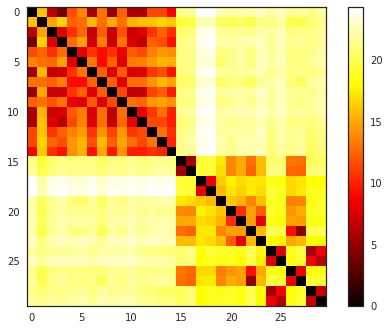

In [121]:
features = extract_features(list_cat)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

corr = []
for f in features:
    corr.append([])
    for ff in features:
        corr[-1].append(np.linalg.norm(f-ff))
#print(corr)
corr = np.array(corr)
#print(corr)

plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

## Load Feature Extractor

In [2]:
model_dir = 'models'
def create_graph():
    with gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
create_graph()
sess = tf.Session()

## Feature Extraction Routine

In [35]:
#Returns the feature vectors corresponding to a list of image
def extract_features(list_images,p=False):
    nb_features = 2048
    features = np.zeros((len(list_images),nb_features))

    labels = []

    next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

    for ind, image in enumerate(list_images):
        if (ind%1 == 0) and p:
            print('Processing %s...' % (image))
        if not gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)

        image_data = gfile.FastGFile(image, 'rb').read()
        predictions = sess.run(next_to_last_tensor,{'DecodeJpeg/contents:0': image_data})
        features[ind,:] = np.squeeze(predictions)
        if p:
            print('Feature vector:', features[ind,:])
        labels.append(io.BytesIO(image_data))
    print("Done")
    return features

## Computing Features

In [36]:
print(list_cat)

['database/apple-2.jpg', 'database/apple-9.jpg', 'database/apple-3.jpg', 'database/apple-5.jpg', 'database/apple-20.jpg', 'database/apple-17.jpg', 'database/apple-4.jpg', 'database/apple-1.jpg', 'database/apple-8.jpg', 'database/apple-10.jpg', 'database/apple-6.jpg', 'database/apple-18.jpg', 'database/apple-19.jpg', 'database/apple-16.jpg', 'database/apple-7.jpg']


In [9]:
#Safety check
len(cat_features),len(query_features)

(210, 210)

## Computing Results
For each queries, the best matching items in the catalogue, according to cosine similarity, are found.

In [10]:
#Cosine Similarity
def sim(vecA,vecB):
    return vecA.dot(vecB)
#Perform the best matching retrieval
#Accuracy: what it means to match, by default it is to be in the top 10 closest
#p: print debug
def query(i_query,accuracy=10,p=False):
    sim_vec = []
    for i in range(len(cat_features)):
        sim_vec.append(sim(query_features[i_query],cat_features[i]))
    sim_vec = np.array(sim_vec)
    arg_s = sim_vec.argsort()[:-accuracy:-1]
    if p:
        print(i_query,arg_s,[sim_vec[i] for i in arg_s], sim_vec[i_query])
    return i_query in arg_s

In [11]:
#Normalization before querying
for i in range(len(cat_features)):
    if not i in to_ignore:
        cat_features[i] /= np.linalg.norm(cat_features[i])
        query_features[i] /= np.linalg.norm(query_features[i])

In [12]:
#Getting result while getting rid of ignored val
matching_frac = 0.0
ignored = 0
for i in range(len(cat_features)):
    if not i in to_ignore:
        matching_frac += query(i)
    else:
        ignored += 1
matching_frac /= (len(cat_features)-ignored)

# Result

In [13]:
print("This method gives a "+str(matching_frac*100)+" 10-accuracy success")

This method gives a 30.0 10-accuracy success


It is **bad** because it doesn't look where it should to identify the dress correctly.